
# Creating coefficients from phase-space snapshots using pyEXP

This example uses the phase-space snapshot files generated by the EXP from the `DiskHaloB` test at https://github.com/EXP-code/EXP-examples

You can generate the phase-space files yourself on a modest use workstation or cluster if you have EXP compiled.  Otherwise, you can use this as a guide for processing your own phase-space snapshots.

We begin by importing `pyEXP` and friends and setting the working directory.

In [1]:
import os
import yaml
import pyEXP
import time
import numpy as np
import matplotlib.pyplot as plt

# I have the Better run here; obviously another use will want to
# change this a directory containing some snapshots of their own
#
os.chdir('../Data')

## Create the basis
We'll only do the halo coefficients in this simple example.  The cylindrical coefficients would procede similarly.  See the `sample_basis` notebook for an example of creating the cylindrical basis.

In [2]:
# Get the basis config
#
# yaml_config = ""
# with open('basis.yaml') as f:
#     config = yaml.load(f, Loader=yaml.FullLoader)
#    yaml_config = yaml.dump(config)

# Alternatively, you could construct this on the fly, e.g.
bconfig = """
---
id: sphereSL
parameters :
  numr: 2000
  rmin: 0.0001
  rmax: 1.95
  Lmax: 6
  nmax: 20
  rmapping:  0.0667
  modelname: SLGridSph.model
  cachename: SLGridSph.cache.run0
...
"""
print('-'*60)
print('Constructed from string')
print('-'*60)
print(bconfig)
print('-'*60)

# Construct the basis instance
#
basis   = pyEXP.basis.Basis.factory(bconfig)

------------------------------------------------------------
Constructed from string
------------------------------------------------------------

---
id: sphereSL
parameters :
  numr: 2000
  rmin: 0.0001
  rmax: 1.95
  Lmax: 6
  nmax: 20
  rmapping:  0.0667
  modelname: SLGridSph.model
  cachename: SLGridSph.cache.run0
...

------------------------------------------------------------
---- SLGridSph::ReadH5Cache: successfully read basis cache <SLGridSph.cache.run0>
SphericalSL::orthoTest: worst=0.000610644


## Creating a particle reader
Now that we have a basis, we can use it to create coefficients from the particle snapshots.  `pyEXP` uses a `ParticleReader` object for that.

The first step is to hand off the files that comprise a snapshot for every time slice.  The `ParticleReader` provides a helper function for that.   There are two helper functions: `parseFileList` and `parseStringList`.  The first reads a list from a file and the second takes a list.  Otherwise they are the same.  The file names in the list are assumed to end with a snapshot index and an optional part index.  For example, if you have single files per snapshot, the list might look like: `myrun.00000`, `myrun.00001`, etc.  If you have multiple files per snapshot, they will look something like `myrun.00000_0001`, `myrun.00000_0002`, `myrun.00001_0000`, `myrun.00001_0001`, etc.

Here is the call for a file:

In [3]:
# Construct batches of files the particle reader.  One could use the
# parseStringList to create batches from a vector/list of files.  NB:
# a std::vector in C++ becomes a Python.list and vice versa
#
batches = pyEXP.read.ParticleReader.parseFileList('file.list', '')

This is my test callback function.  It will print the first 10 particles just to convince us that it is working, 

In [4]:
def selection(mass, pos, vel, index):
    if index<=10:
        print('index, mass, x, y, z =', index, mass, pos[0], pos[1], pos[2])
    return True

basis.setSelector(selection)

Here is a center of mass functor...

In [5]:
totalMass = 0.0
com = [0.0, 0.0, 0.0]
def makeCOM(mass, pos, vel, index):
    global totalMass, com
    totalMass += mass
    for i in range(3): com[i] += mass * pos[i]

We now iterate the `batches` created by the file parser to create the coefficients.   For each batch we create a new reader and pass the reader to the basis instance.  The `basis.createFromReader` member creates and returns the coefficients.  The coefficients are added to a coefficient container called `coefs`.  Note: on the first call `coefs=None` so a new container is created on the first time through.

In [6]:
# This will contain the coefficient container, need to start will a
# null instance to trigger construction
#
coefs   = None

begin = time.time()

for group in batches:

    print("file group is", group)

    # Make the reader for the desired type.  One could probably try to
    # do this by inspection but that's another project.
    #
    reader = pyEXP.read.ParticleReader.createReader('PSPout', group, 0, False);

    # Print the type list
    #
    print('The component names are:', reader.GetTypes())

    compname = 'dark halo'
    reader.SelectType(compname)
    print('Selected', compname)

    print('Call createFromReader at Time', reader.CurrentTime(), 'for', reader.CurrentNumber(), 'particles')

    coef = basis.createFromReader(reader)
    print("Created coef")
    
    print("Testing the density center creation")
   
    center = pyEXP.util.getDensityCenter(reader, stride=1, Nsort=1000)
    print("Density center is", center)
    
    print("Testing the particle iterator by computing COM")
    totalMass = 0.0
    com = [0.0, 0.0, 0.0]
    pyEXP.util.particleIterator(reader, makeCOM)
    print("Center of mass is", com[0]/totalMass, com[1]/totalMass, com[2]/totalMass)

    # We need this stupid idiom here because None is not mapping to a
    # null pointer.  There is probably a way to do this.  Suggestions
    # anyone?
    #                          This is optional---+
    #                                             |
    if coefs is None:           #                 v
        coefs = pyEXP.coefs.Coefs.makecoefs(coef, compname)
    else:
        coefs.add(coef)

    print('Added coef')
    print('-'*60)

print('\nCompleted the file group list\n')

print('The coefficient time list is', coefs.Times())
print('Elapsed time:', time.time() - begin)

file group is ['OUT.run0.00000']
The component names are: ['dark halo', 'star disk']
Selected dark halo
Call createFromReader at Time 0.0 for 100000 particles
index, mass, x, y, z = 1 9.651515028963331e-06 0.941630482673645 0.6668369770050049 0.7036028504371643
index, mass, x, y, z = 2 6.243539019124e-07 0.002228023484349251 -0.0017561642453074455 8.763065852690488e-05
index, mass, x, y, z = 3 1.4266431207943242e-05 0.6066200733184814 0.40197044610977173 -0.8750137090682983
index, mass, x, y, z = 4 1.91562830877956e-05 0.18146848678588867 0.019536208361387253 -0.04939988628029823
index, mass, x, y, z = 5 1.0565162483544555e-05 0.9574946761131287 -0.2784556746482849 0.46641644835472107
index, mass, x, y, z = 6 1.897938818729017e-05 -0.10535112023353577 -0.026948699727654457 -0.030037209391593933
index, mass, x, y, z = 7 1.0126675988431089e-05 0.6734440922737122 0.8086175322532654 -0.5085681080818176
index, mass, x, y, z = 8 1.4755632037122268e-05 0.7752076387405396 -1.1270403861999512 0

## Using a FieldGenerator
Now that we have our new coefficients, we can use the `FieldGenerator` to view the BFE representation of the underlying fields.  Here is an example:

In [7]:
# Now try some slices for rendering
#

times = coefs.Times()[0:3]
pmin  = [-1.0, -1.0, 0.0]
pmax  = [ 1.0,  1.0, 0.0]
grid  = [  40,   40,   0]

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

surfaces = fields.slices(basis, coefs)

print("We now have the following [time field] pairs")
for v in surfaces:
    print('-'*40)
    for u in surfaces[v]:
        print("{:8.4f}  {}".format(v, u))

print("\nHere is the first one:")
for v in surfaces:
    for u in surfaces[v]:
        print('-'*40)
        print('----', u)
        print('-'*40)
        print(surfaces[v][u])
    break

We now have the following [time field] pairs
----------------------------------------
  0.0100  azi force
  0.0100  dens
  0.0100  dens m=0
  0.0100  dens m>0
  0.0100  mer force
  0.0100  potl
  0.0100  potl m=0
  0.0100  potl m>0
  0.0100  rad force
----------------------------------------
  0.0200  azi force
  0.0200  dens
  0.0200  dens m=0
  0.0200  dens m>0
  0.0200  mer force
  0.0200  potl
  0.0200  potl m=0
  0.0200  potl m>0
  0.0200  rad force
----------------------------------------
  0.0300  azi force
  0.0300  dens
  0.0300  dens m=0
  0.0300  dens m>0
  0.0300  mer force
  0.0300  potl
  0.0300  potl m=0
  0.0300  potl m>0
  0.0300  rad force

Here is the first one:
----------------------------------------
---- azi force
----------------------------------------
[[-9.4884116e-04 -1.1409925e-03 -1.3691135e-03 ...  1.4666337e-04
   1.9595698e-04  3.2692225e-04]
 [-1.4397600e-03 -1.7435353e-03 -2.0801881e-03 ... -2.8524455e-05
   1.1004305e-05  1.4322114e-04]
 [-2.0527244e-0

azi force
dens
dens m=0
dens m>0
mer force
potl
potl m=0
potl m>0
rad force


Text(0, 0.5, 'y')

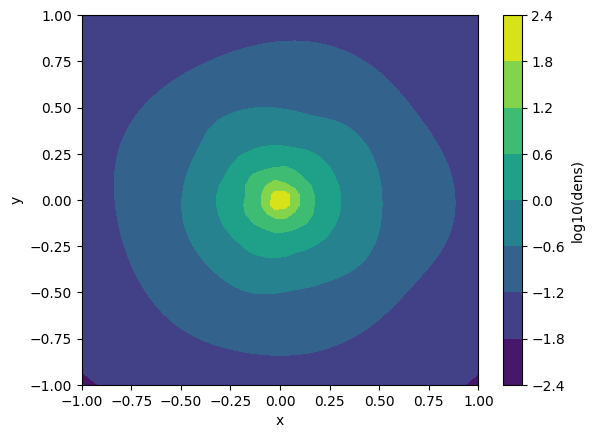

In [8]:
for v in surfaces[0.03]: print(v)
x0 = np.arange(pmin[0], pmax[0]+0.0001, (pmax[0] - pmin[0])/(grid[0]-1))
y0 = np.arange(pmin[1], pmax[1]+0.0001, (pmax[1] - pmin[1])/(grid[1]-1))
x, y = np.meshgrid(x0, y0)
c = plt.contourf(x0, y0, np.log10(surfaces[0.03]['dens']))
plt.colorbar(c, label='log10(dens)')
plt.xlabel('x')
plt.ylabel('y')

## Basis orthgonality check

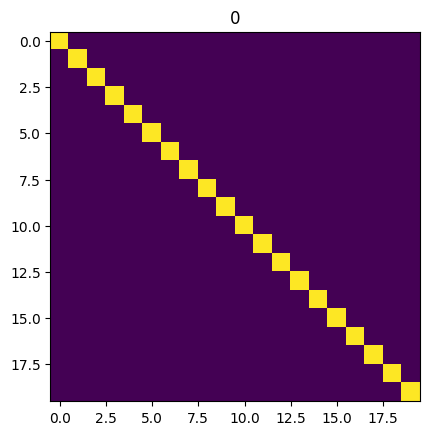

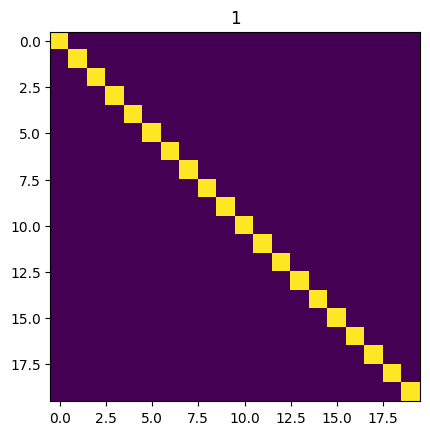

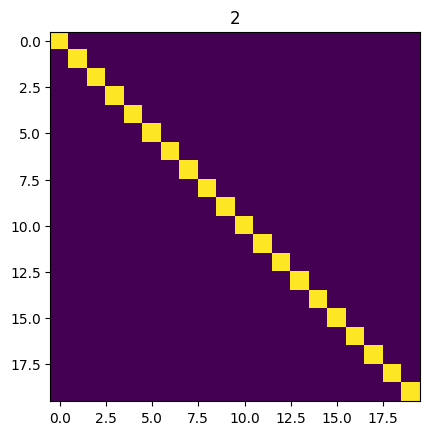

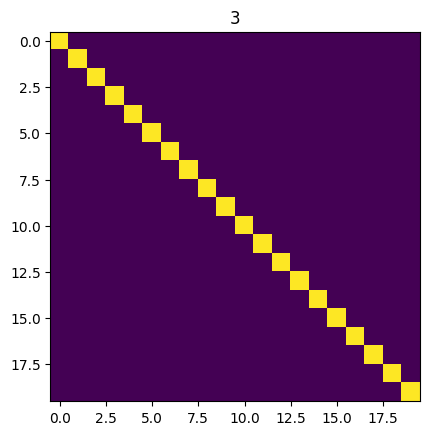

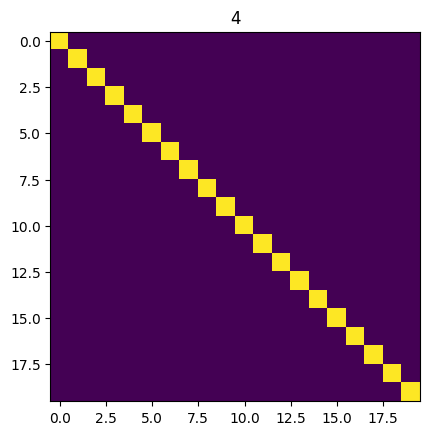

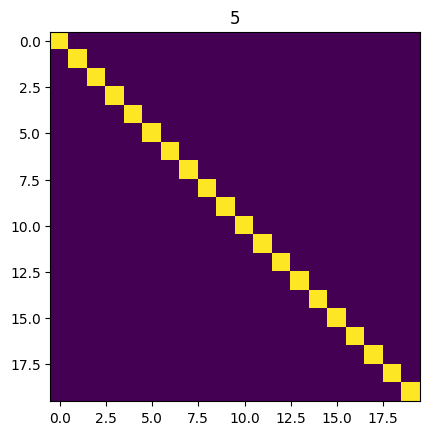

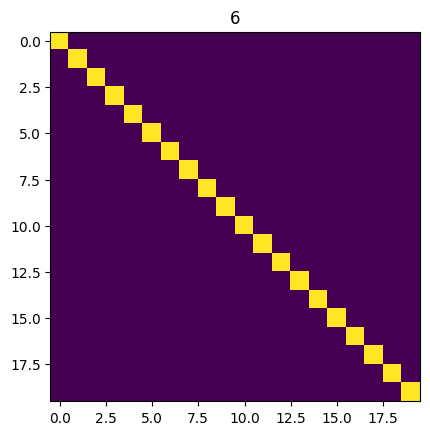

In [9]:
X = np.array(basis.orthoCheck())
for m in range(X.shape[0]):
    plt.imshow(X[0,:,:])
    plt.title('{}'.format(m))
    plt.show()

These could be make into images and so forth.   We'll do this in another example notebook.

## Saving the coefficients

At this point, it makes sense to save the coefficients that you have just created.  This is sone with the following call:

In [10]:
coefs.WriteH5Coefs('test_coefs')

We now have a EXP HDF5 coefficient file called `test_coefs`.    As an example, let's try reading the newly created file into another coefficient container, `coefs2`.  The container has a member function called `CompareStanzas` which will check on the contents.  Let's do it.

In [11]:
# Now try reading it in
#
coefs2 = pyEXP.coefs.Coefs.factory('test_coefs')
print("Type is", coefs2.getGeometry())

# Now compare with the original
#
coefs2.CompareStanzas(coefs)

Type is sphere


True

Times are the same, now checking parameters at each time
Parameters are the same, now checking coefficients


This member function will print differences.  No differenced should be printed, of course.

### Clean up

In [12]:
os.remove('test_coefs')